In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
# Basics
import tensorflow as tf
import xarray as xr
import random

# Helpful
import tqdm

# Visualization
import matplotlib.pyplot as plt

# Path setup
import sys

sys.path.append("/home/dchen/BA_CH_EN/")

# My Methods
from src.utils.CRPS import *  # CRPS metrics
from src.utils.data_split import *  # Splitting data into X and y
from src.utils.drn_make_X_array import *  # Import make train array functions (make_X_array)
from src.models.EMOS import *  # EMOS implementation
from src.models.EMOS_global.EMOS_global_load_score import *  # Load EMOS_global_scores
from src.models.EMOS_global.EMOS_global_load_model import *  # Load EMOS_global_models
from src.models.EMOS_local.EMOS_local_load_score import *  # Load EMOS_local_scores
from src.models.EMOS_local.EMOS_local_load_model import *  # Load EMOS_local_models
from src.models.DRN.DRN_model import *  # DRN implementation
from src.models.DRN.DRN_load_score import *  # Load DRN_scores
from src.models.DRN.DRN_load_score_10 import *  # Load DRN_scores_10
from src.models.DRN.DRN_load_score_dummy_10 import *  # Load DRN_scores_10
import data.raw.load_data_raw as ldr  # Load raw data
import data.processed.load_data_processed as ldp  # Load processed data normed
import data.processed.load_data_processed_denormed as ldpd  # Load processed data denormed
from src.models.CRPS_baseline.CRPS_load import *  # Load CRPS scores
from src.models.U_net.u_net_load_score import *
from src.models.U_net.u_net_load_preds import *

<IPython.core.display.Javascript object>

### 0. Setup

### 1. Load Scores

In [4]:
# Baseline Scores
CRPS_baseline_scores_t2m = crps_load_lead_lat_lon("t2m")
CRPS_baseline_scores_ws10 = crps_load_lead_lat_lon("ws10")

# Global Scores:
EMOS_glob_scores_t2m = EMOS_global_load_score("t2m")
EMOS_glob_scores_ws10 = EMOS_global_load_score("ws10")

# Local Scores:
EMOS_loc_scores_t2m = EMOS_local_load_score("t2m")
EMOS_loc_scores_ws10 = EMOS_local_load_score("ws10")

# DRN 10 dummy scores:
DRN_scores_t2m_dummy_10 = DRN_load_score_dummy_10("t2m")
DRN_scores_ws10_dummy_10 = DRN_load_score_dummy_10("ws10")

# U-net scores:
u_net_scores_t2m = u_net_load_score("t2m")
u_net_scores_ws10 = u_net_load_score("ws10")

<IPython.core.display.Javascript object>

### 1.1 Final Scores

In [6]:
print(
    f"t2m final scores: raw {np.mean(CRPS_baseline_scores_t2m)}, EMOS_global {np.mean(EMOS_glob_scores_t2m)}"
)
print(
    f"t2m final scores: EMOS_local {np.mean(EMOS_loc_scores_t2m)}, DRN {np.mean(DRN_scores_t2m_dummy_10)}"
)
print(f"t2m final scores: U-net {np.mean(u_net_scores_t2m)}")

t2m final scores: raw 0.9180354663711785, EMOS_global 0.8378966859570394
t2m final scores: EMOS_local 0.8146924812620132, DRN 0.777988935439267
t2m final scores: U-net 0.8292138685529086


<IPython.core.display.Javascript object>

In [7]:
print(
    f"ws10 final scores: raw {np.mean(CRPS_baseline_scores_ws10)}, EMOS_global {np.mean(EMOS_glob_scores_ws10)}"
)
print(
    f"ws10 final scores: EMOS_local {np.mean(EMOS_loc_scores_ws10)}, DRN {np.mean(DRN_scores_ws10_dummy_10)}"
)
print(f"ws10 final scores: U-net {np.mean(u_net_scores_ws10)}")


ws10 final scores: raw 1.0906319618225098, EMOS_global 1.036388874053955
ws10 final scores: EMOS_local 1.0209756239684493, DRN 1.008193850517273
ws10 final scores: U-net 1.0697252750396729


<IPython.core.display.Javascript object>

### 2. Diagram Comparison

In [33]:
def line_chart_all_scores(var_name, models=[True, True, True, True, True], land_sea = None):
    """
    Plot a line chart with all of the mean scores over the lead_times.
    Args:
        var_name (str): Variable name to use for comparison
        models (list): Which models to add to the graph. 
    Returns:
        None
    """
    # Load all scores
    load_funcs = [
        crps_load_lead_lat_lon,
        EMOS_global_load_score,
        EMOS_local_load_score,
        DRN_load_score_dummy_10,
        u_net_load_score,  # Added the U-net model's load function
    ]
    all_scores = []
    for count, boolean in enumerate(models):
        if boolean:
            all_scores.append(load_funcs[count](var_name))

    # All same shape: (31, 120, 130)
    all_scores_mean = []
    if land_sea != None:
        land_sea_mask_dummy = np.load(
            "/Data/Delong_BA_Data/land_sea_mask_dummy/land_sea_mask_dummy.npy"
        )
        if land_sea == 0:
            land_sea_mask_dummy = np.logical_not(land_sea_mask_dummy)
            
        for model in range(len(all_scores)):
            all_scores_mean.append([])
            for lead_time in range(31):
                all_scores_mean[model].append(all_scores[model][lead_time][land_sea_mask_dummy == 1].mean())
    else:
        # Making mean scores:
        all_scores_mean = []
        for model in range(len(all_scores)):
            all_scores_mean.append([])
            for lead_time in range(31):
                all_scores_mean[model].append(all_scores[model][lead_time].mean())

    # Deciding on which scores to use:
    model_scores = all_scores_mean
    N = 31

    # Plotting line charts
    ind = np.arange(1, N + 1) * 6  # the x locations for the groups

    fig, ax = plt.subplots(figsize=(10, 6))

    labels_all = ["Raw Ensemble", "EMOS_global", "EMOS_local", "DRN", "U-net"]  # Added "U-net" to the labels
    colors_all = ["yellow", "green", "blue", "red", "black"]  # Added "black" to the colors

    labels_models = []
    colors_models = []
    for count, boolean in enumerate(models):
        if boolean:
            labels_models.append(labels_all[count])
            colors_models.append(colors_all[count])

    # Iterate through lead times
    for model_index in range(len(labels_models)):
        ax.plot(
            ind,
            model_scores[model_index],
            color=colors_models[model_index],
            label=labels_models[model_index],
        )

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel("Lead Times in Hours")
    ax.set_ylabel("Crps Scores")
    ax.set_title("Scores by lead time: " + var_name)
    ax.set_xticks(ind)
    ax.set_xticklabels([str(i) for i in ind])
    plt.xticks(rotation=60)
    ax.legend()
#     plt.savefig(
#         f"/home/dchen/BA_CH_EN/reports/figures/crps_scores_per_grid_post_processing_{var_name}.pdf"
#     )
    plt.show()

<IPython.core.display.Javascript object>

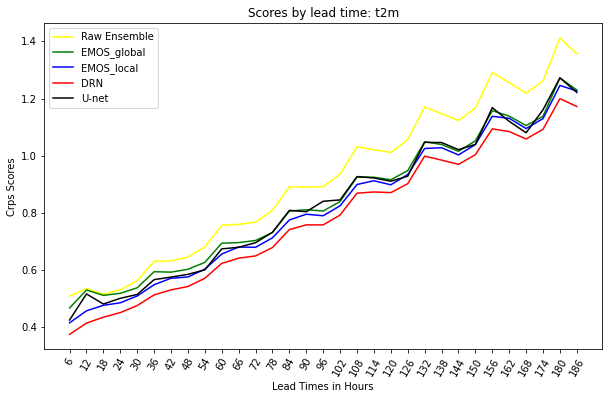

<IPython.core.display.Javascript object>

In [52]:
line_chart_all_scores("t2m", land_sea=None)

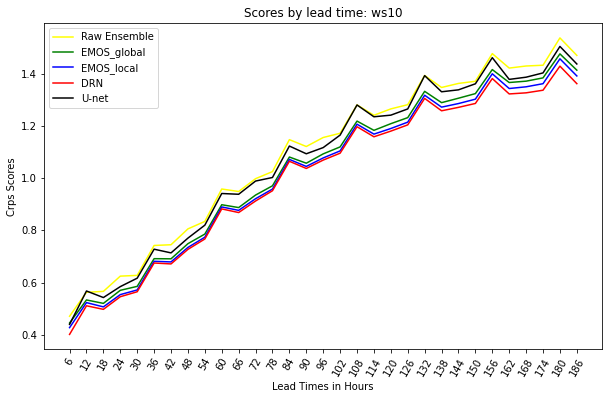

<IPython.core.display.Javascript object>

In [53]:
line_chart_all_scores("ws10", models=[True, True, True, True, True], land_sea=None)

### 3. Maps

In [59]:
def heatmap_lead(var_name, lead_time, models=[True, True, True, True, True]):
    """
    Plots the specified number of heatmaps of the scores for a specified lead time
    Args:
        var_name (str): variable to use 
        lead_time (int): Lead time 0 - 30
        models (list): Boolean list determining which models to plot
    Returns:
        None
    """
    # Load lead_time specific scores
    load_funcs = [
        crps_load_lead_lat_lon,
        EMOS_global_load_score,
        EMOS_local_load_score,
        DRN_load_score,
        u_net_load_score,  # Added the U-net model's load function
    ]
    all_mean_scores = []
    for count, boolean in enumerate(models):
        if boolean:
            all_mean_scores.append(load_funcs[count](var_name)[lead_time])
    # All same shape: 120x130

    # Decide on labels
    labels_all = [
        "CRPS_baseline",
        "EMOS_glob",
        "EMOS_loc",
        "DRN",
        "U-net",
    ]  # Added "U-net" to the labels
    labels_models = []
    for count, boolean in enumerate(models):
        if boolean:
            labels_models.append(labels_all[count])

    # Find global min and max across all datasets
    vmin = np.min([np.min(scores) for scores in all_mean_scores])
    vmax = np.max([np.max(scores) for scores in all_mean_scores])

    # Plot heat maps
    fig, axs = plt.subplots(len(all_mean_scores), 1, figsize=(30, 20))
    for model in range(len(all_mean_scores)):
        im = axs[model].imshow(
            all_mean_scores[model], cmap="viridis", vmin=vmin, vmax=vmax
        )
        fig.colorbar(
            im, ax=axs[model], label="your label"
        )  # add colorbar to the figure and associate it with the axis
        axs[model].set_title(
            f"Colormap {labels_models[model]} score, lead_time {lead_time}"
        )
    plt.show()

<IPython.core.display.Javascript object>

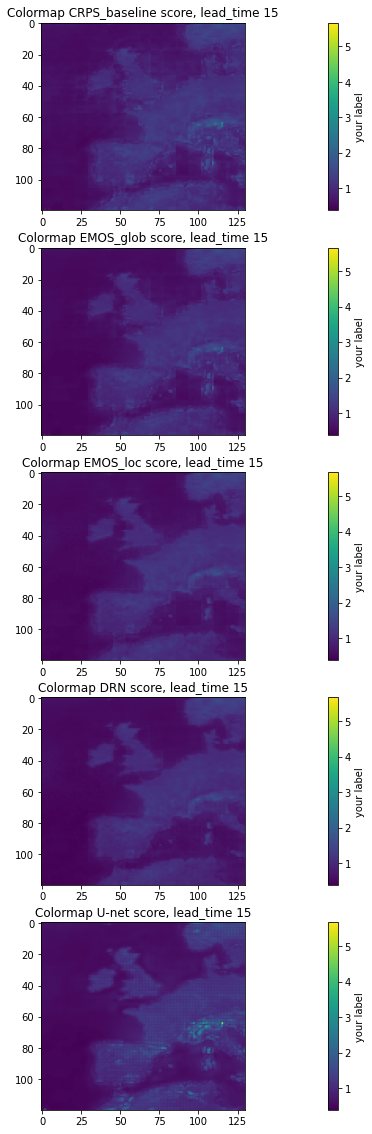

<IPython.core.display.Javascript object>

In [60]:
heatmap_lead("t2m", 15)

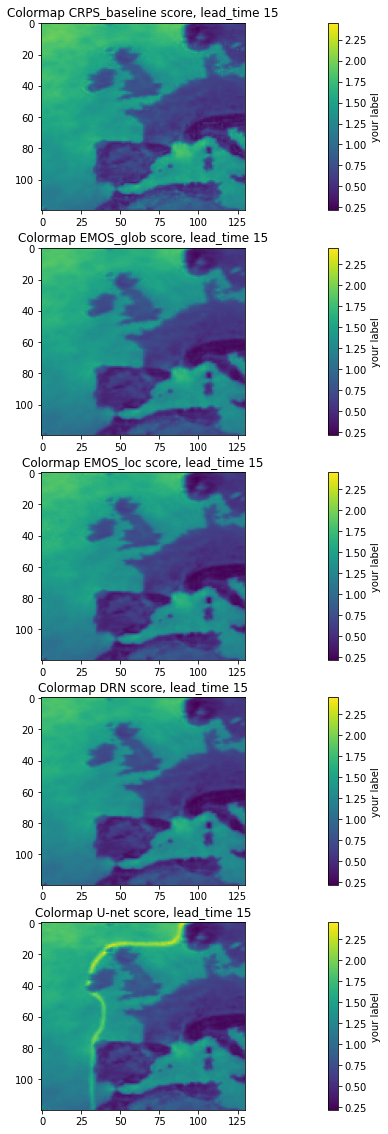

<IPython.core.display.Javascript object>

In [62]:
heatmap_lead("ws10", 15)

### 4. Boxplots

#### 4.1 Boxplot all lead_times

In [15]:
def box_plot_all_scores(var_name, binned=False, models=[True, True, True, True]):
    """
    Plot a box plot with all of the scores over the lead_times. Either binned or not
Args:
    var_name (str): Variable name to use for comparison
    binned (bool): Whether to bin the lead_times together in bins of 5 or not
    models (list): Which models to add to the graph. 
Returns: 
    None
    """
    # Load all scores
    load_funcs = [
        crps_load_lead_lat_lon,
        EMOS_global_load_score,
        EMOS_local_load_score,
        DRN_load_score,
    ]
    all_scores = []
    for count, boolean in enumerate(models):
        if boolean:
            all_scores.append(load_funcs[count](var_name))
    # All same shape: (31, 120, 130)

    # Making mean scores:
    all_scores_mean = []
    all_scores_mean_binned = []
    for model in range(len(all_scores)):
        all_scores_mean.append([])
        for lead_time in range(31):
            all_scores_mean[model].append(all_scores[model][lead_time].mean())

    for model in range(len(all_scores)):
        if binned:
            chunks = [all_scores_mean[model][i : i + 5] for i in range(0, 25, 5)] + [
                all_scores_mean[model][-6:]
            ]
            all_scores_mean_binned.append([np.mean(chunk) for chunk in chunks])

    # Deciding on which scores to use:
    if binned:
        model_scores = all_scores_mean_binned
        N = 6
    else:
        model_scores = all_scores_mean
        N = 31

    # Deciding on which labels to use
    labels_all = ["CRPS_baseline", "EMOS_glob", "EMOS_loc", "DRN"]
    labels_models = []

    for count, boolean in enumerate(models):
        if boolean:
            labels_models.append(labels_all[count])

    # Plotting box plots
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.boxplot(model_scores, labels=labels_models, notch=False)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel("Models")
    ax.set_title("Scores by Array and Index")
    ax.set_xticklabels(labels_models)
    plt.xticks(rotation=60)

    plt.show()

<IPython.core.display.Javascript object>

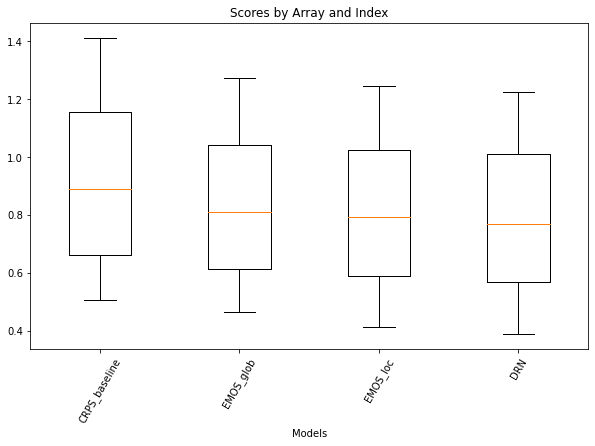

<IPython.core.display.Javascript object>

In [16]:
box_plot_all_scores("t2m")

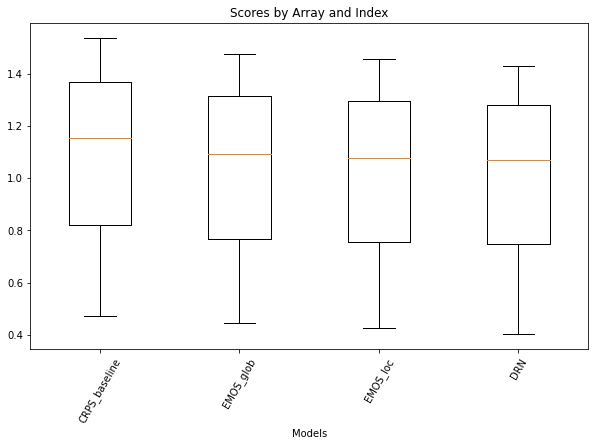

<IPython.core.display.Javascript object>

In [17]:
box_plot_all_scores("ws10", models=[True, True, True, True])

#### 4.2 Boxplot one lead_time

In [18]:
def box_plot_lead_time_scores(var_name, lead_time, models=[True, True, True, True]):
    """
    Plot a box plot with all of the scores over one lead_time. Either binned or not
Args:
    var_name (str): Variable name to use for comparison
    lead_time(int): Between 0 - 30, decided which lead_time to use.
    models (list): Which models to add to the graph. 
Returns:
    None
    """
    # Load lead_time specific scores
    load_funcs = [
        crps_load_lead_lat_lon,
        EMOS_global_load_score,
        EMOS_local_load_score,
        DRN_load_score,
    ]
    all_mean_scores = []
    for count, boolean in enumerate(models):
        if boolean:
            all_mean_scores.append(load_funcs[count](var_name)[lead_time].flatten())
    # All same shape: 120x130

    # Deciding on which labels to use
    labels_all = ["CRPS_baseline", "EMOS_glob", "EMOS_loc", "DRN"]
    labels_models = []

    for count, boolean in enumerate(models):
        if boolean:
            labels_models.append(labels_all[count])

    # Plotting box plots
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.boxplot(all_mean_scores, labels=labels_models, notch=True)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel("Models")
    ax.set_title(f"Scores, lead_time {lead_time}")
    ax.set_xticklabels(labels_models)
    plt.xticks(rotation=60)

    plt.show()

<IPython.core.display.Javascript object>

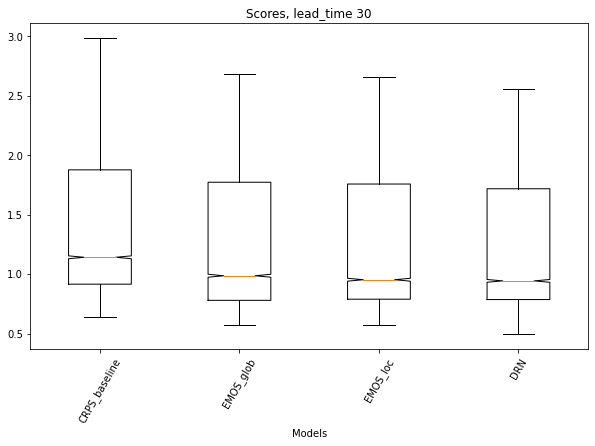

<IPython.core.display.Javascript object>

In [19]:
box_plot_lead_time_scores("t2m", 30)

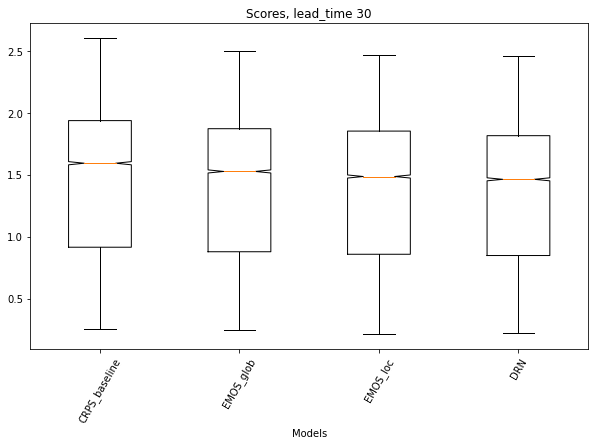

<IPython.core.display.Javascript object>

In [21]:
box_plot_lead_time_scores("ws10", 30, models=[True, True, True, True])